In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot

pd.options.plotting.backend = "plotly"

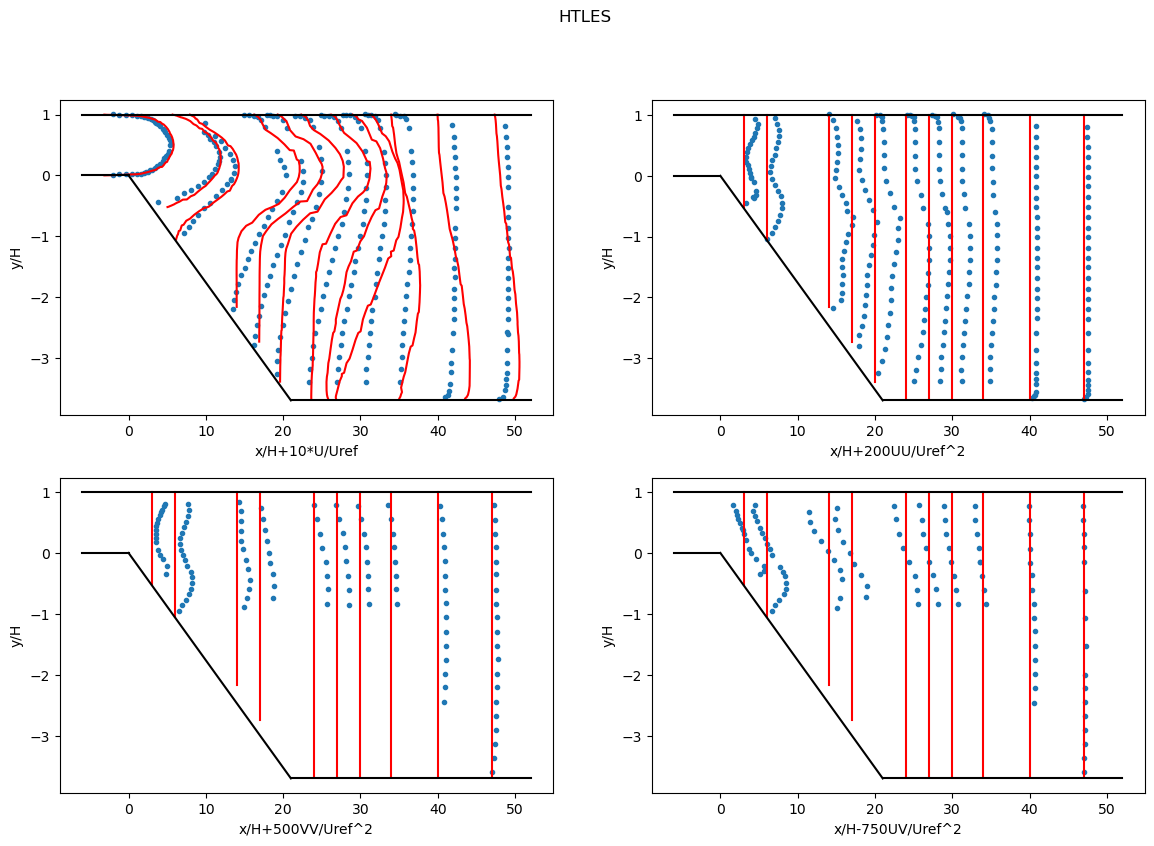

\addplot+[green,thick,solid,no marks,forget plot] table[x=cfd_-0.06x_u_x,y=cfd_-0.06x_u_y,col sep=comma]{Graphs/Diffuser/Diffuser_graphs_SKE.csv};
\addplot+[green,thick,solid,no marks] table[x=cfd_0.03x_u_x,y=cfd_0.03x_u_y,col sep=comma]{Graphs/Diffuser/Diffuser_graphs_SKE.csv};
\addlegendentry{{STRUCT-$\varepsilon$}};
\addplot+[green,thick,solid,no marks,forget plot] table[x=cfd_0.06x_u_x,y=cfd_0.06x_u_y,col sep=comma]{Graphs/Diffuser/Diffuser_graphs_SKE.csv};
\addplot+[green,thick,solid,no marks,forget plot] table[x=cfd_0.14x_u_x,y=cfd_0.14x_u_y,col sep=comma]{Graphs/Diffuser/Diffuser_graphs_SKE.csv};
\addplot+[green,thick,solid,no marks,forget plot] table[x=cfd_0.17x_u_x,y=cfd_0.17x_u_y,col sep=comma]{Graphs/Diffuser/Diffuser_graphs_SKE.csv};
\addplot+[green,thick,solid,no marks,forget plot] table[x=cfd_0.20x_u_x,y=cfd_0.20x_u_y,col sep=comma]{Graphs/Diffuser/Diffuser_graphs_SKE.csv};
\addplot+[green,thick,solid,no marks,forget plot] table[x=cfd_0.24x_u_x,y=cfd_0.24x_u_y,col sep=com

In [10]:
global Diffuser_h
Diffuser_h =0.015
global U_ref
U_ref = 18.32


experiment_dif = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/diffuser_inlet.csv")
experiment_uu = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/u_variance.csv")
experiment_uv = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/uv_covariance.csv")
experiment_vv = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/v_variance.csv")

Struct_cubic = {"Profiles_Path":Path("/home/juleslecoustre/Documents/Acqua/Diffuser/STRUCT_Cubic_GCR/profiles"),
                "measures":["-0.06","0.03","0.06","0.14","0.17","0.20","0.24","0.27","0.30","0.34","0.40","0.47"],
                "Iter":"50000",
                "Name":"GCR"}

HTLES = {"Profiles_Path":Path("/home/juleslecoustre/Documents/Acqua/Diffuser/HTLES_OMG_2/profiles"),
                "measures":["-0.06","0.03","0.06","0.14","0.17","0.20","0.24","0.27","0.30","0.34","0.40","0.47"],
                "Iter":"50000",
                "Name":"HTLES"}

SKE = {"Profiles_Path":Path("/home/juleslecoustre/Documents/Acqua/Diffuser/SKE/profiles"),
                "measures":["-0.06","0.03","0.06","0.14","0.17","0.20","0.24","0.27","0.30","0.34","0.40","0.47"],
                "Iter":"30000",
                "Name":"SKE"}

cases = [HTLES]

for case in cases:
  df_save = pd.DataFrame()
  df_save_exp = pd.DataFrame()
  txt = ""
  Profiles_Path = case["Profiles_Path"]
  measures = case["measures"]
  Iter = case["Iter"]
  Name = case["Name"]
  fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(14,9))
  fig.suptitle(Name)
  ax=axes[0][0]
  for mes in measures:
    df = pd.read_csv(Profiles_Path.joinpath("{0}x_{1}.csv".format(mes,Iter)))
    col2  = []
    for col in df.columns:
        col2.append(str(col).strip(' '))
    df.columns = col2
    df["x/H+10U/Uref"] = df["x"]/Diffuser_h + 10*df["U_avg"]/U_ref
    df["y/H"] = df["y"]/Diffuser_h
    ax.plot(df["x/H+10U/Uref"],df["y/H"],c="r")
    df_save["cfd_{}x_u_x".format(mes)] = df["x/H+10U/Uref"]
    df_save["cfd_{}x_u_y".format(mes)] = df["y/H"]
    if mes != "0.03":
      txt += "\\addplot+[green,thick,solid,no marks,forget plot] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_u_x".format(mes),"cfd_{}x_u_y".format(mes))
    else:
      txt += "\\addplot+[green,thick,solid,no marks] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_u_x".format(mes),"cfd_{}x_u_y".format(mes))
      txt+="\\addlegendentry{{STRUCT-$\\varepsilon$}};\n"
  ax.scatter(experiment_dif["x"],experiment_dif["y1"]/Diffuser_h,marker='.')
  df_save_exp["exp_u_x"] = experiment_dif["x"]
  df_save_exp["exp_u_y"] = experiment_dif["y1"]/Diffuser_h
  #txt += "\\addplot+[only marks, black,thick,mark options={{scale=\ScaleDiff}},mark=*] table[x=exp_u_x,y=exp_u_y,col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_exp.csv}};\n\\addlegendentry{{Experiment}};\n".format()
  ax.plot([-6,0],[0,0],c="black")
  ax.plot([0,21],[0,-3.7],c="black")
  ax.plot([21,52],[-3.7,-3.7],c="black")
  ax.plot([-6,52],[1,1],c="black")
  ax.set_xlabel("x/H+10*U/Uref")
  ax.set_ylabel("y/H")
  txt += "\n\n"


  if "-0.06" in measures:
    measures.remove("-0.06")
  ax=axes[0][1]
  for mes in measures:
    df = pd.read_csv(Profiles_Path.joinpath("{0}x_{1}.csv".format(mes,Iter)))
    col2  = []
    for col in df.columns:
        col2.append(str(col).strip(' '))
    df.columns = col2
    df["x/H+200UU/Uref^2"] = df["x"]/Diffuser_h + 200*df["UU_avg"]/U_ref**2
    df["y/H"] = df["y"]/Diffuser_h
    df_save["cfd_{}x_uu_x".format(mes)] = df["x/H+200UU/Uref^2"]
    df_save["cfd_{}x_uu_y".format(mes)] = df["y/H"]
    ax.plot(df["x/H+200UU/Uref^2"],df["y/H"],c="r")
    if mes != "0.03":
      txt += "\\addplot+[green,thick,solid,no marks,forget plot] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_uu_x".format(mes),"cfd_{}x_uu_y".format(mes))
    else:
      txt += "\\addplot+[green,thick,solid,no marks] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_uu_x".format(mes),"cfd_{}x_uu_y".format(mes))
      txt+="\\addlegendentry{{STRUCT-$\\varepsilon$}};\n"
  ax.scatter(experiment_uu["x"],experiment_uu["y1"]/Diffuser_h,marker='.')
  df_save_exp["exp_uu_x"] = experiment_uu["x"]
  df_save_exp["exp_uu_y"] = experiment_uu["y1"]/Diffuser_h
  #txt += "\\addplot+[only marks, black,thick,mark options={{scale=\ScaleDiff}},mark=*] table[x=exp_uu_x,y=exp_uu_y,col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_exp.csv}};\n\\addlegendentry{{Experiment}};\n".format()
  ax.plot([-6,0],[0,0],c="black")
  ax.plot([0,21],[0,-3.7],c="black")
  ax.plot([21,52],[-3.7,-3.7],c="black")
  ax.plot([-6,52],[1,1],c="black")
  ax.set_xlabel("x/H+200UU/Uref^2")
  ax.set_ylabel("y/H")
  txt += "\n\n"

  if "0.20" in measures:
    measures.remove("0.20")
  ax=axes[1][0]
  for mes in measures:
    df = pd.read_csv(Profiles_Path.joinpath("{0}x_{1}.csv".format(mes,Iter)))
    col2  = []
    for col in df.columns:
        col2.append(str(col).strip(' '))
    df.columns = col2
    df["x/H+500VV/Uref^2"] = df["x"]/Diffuser_h + 500*df["VV_avg"]/U_ref**2
    df["y/H"] = df["y"]/Diffuser_h
    df_save["cfd_{}x_vv_x".format(mes)] = df["x/H+500VV/Uref^2"]
    df_save["cfd_{}x_vv_y".format(mes)] = df["y/H"]
    ax.plot(df["x/H+500VV/Uref^2"],df["y/H"],c="r")
    if mes != "0.03":
      txt += "\\addplot+[green,thick,solid,no marks,forget plot] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_vv_x".format(mes),"cfd_{}x_vv_y".format(mes))
    else:
      txt += "\\addplot+[green,thick,solid,no marks] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_vv_x".format(mes),"cfd_{}x_vv_y".format(mes))
      txt+="\\addlegendentry{{STRUCT-$\\varepsilon$}};\n"
  ax.scatter(experiment_vv["x"],experiment_vv["y1"]/Diffuser_h,marker='.')
  df_save_exp["exp_vv_x"] = experiment_vv["x"]
  df_save_exp["exp_vv_y"] = experiment_vv["y1"]/Diffuser_h
  #txt += "\\addplot+[only marks, black,thick,mark options={{scale=\ScaleDiff}},mark=*] table[x=exp_vv_x,y=exp_vv_y,col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_exp.csv}};\n\\addlegendentry{{Experiment}};\n".format()
  ax.plot([-6,0],[0,0],c="black")
  ax.plot([0,21],[0,-3.7],c="black")
  ax.plot([21,52],[-3.7,-3.7],c="black")
  ax.plot([-6,52],[1,1],c="black")
  ax.set_xlabel("x/H+500VV/Uref^2")
  ax.set_ylabel("y/H")
  txt += "\n\n"

  ax=axes[1][1]
  for mes in measures:
    df = pd.read_csv(Profiles_Path.joinpath("{0}x_{1}.csv".format(mes,Iter)))
    col2  = []
    for col in df.columns:
        col2.append(str(col).strip(' '))
    df.columns = col2
    df["x/H-750UV/Uref^2"] = df["x"]/Diffuser_h - 750*df["UV_avg"]/U_ref**2
    df["y/H"] = df["y"]/Diffuser_h
    ax.plot(df["x/H-750UV/Uref^2"],df["y/H"],c="r")
    df_save["cfd_{}x_uv_x".format(mes)] = df["x/H-750UV/Uref^2"]
    df_save["cfd_{}x_uv_y".format(mes)] = df["y/H"]
    if mes != "0.03":
      txt += "\\addplot+[green,thick,solid,no marks,forget plot] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_uv_x".format(mes),"cfd_{}x_uv_y".format(mes))
    else:
      txt += "\\addplot+[green,thick,solid,no marks] table[x={},y={},col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_SKE.csv}};\n".format("cfd_{}x_uv_x".format(mes),"cfd_{}x_uv_y".format(mes))
      txt+="\\addlegendentry{{STRUCT-$\\varepsilon$}};\n"
  ax.scatter(experiment_uv["x"],experiment_uv["y1"]/Diffuser_h,marker='.')
  df_save_exp["exp_uv_x"] = experiment_uv["x"]
  df_save_exp["exp_uv_y"] = experiment_uv["y1"]/Diffuser_h
  #txt += "\\addplot+[only marks, black,thick,mark options={{scale=\ScaleDiff}},mark=*] table[x=exp_uv_x,y=exp_uv_y,col sep=comma]{{Graphs/Diffuser/Diffuser_graphs_exp.csv}};\n\\addlegendentry{{Experiment}};\n".format()
  ax.plot([-6,0],[0,0],c="black")
  ax.plot([0,21],[0,-3.7],c="black")
  ax.plot([21,52],[-3.7,-3.7],c="black")
  ax.plot([-6,52],[1,1],c="black")
  ax.set_xlabel("x/H-750UV/Uref^2")
  ax.set_ylabel("y/H")
plt.show()
df_save.to_csv("Diffuser_graphs_SKE.csv")
df_save_exp.to_csv("Diffuser_graphs_exp.csv")
print(txt)

/home/juleslecoustre/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning:

Polyfit may be poorly conditioned



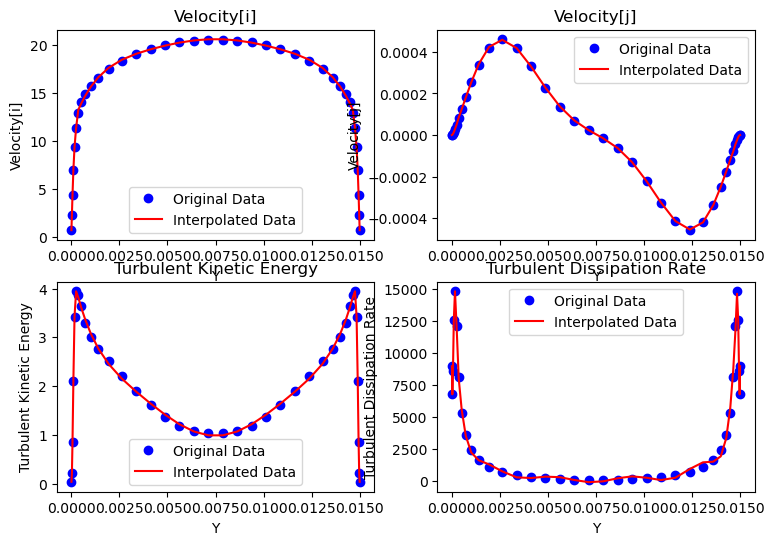

In [4]:
# Input data as a pandas DataFrame
data = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/Inlet_fully_developed.csv")

# Variable names
variable_names = ['Velocity[i]', 'Velocity[j]', 'Turbulent Kinetic Energy', 'Turbulent Dissipation Rate']

# Extract Y values
y = data['Y'].values
ymax = np.max(y)
ymin = np.min(y)

# Interpolate each column
interpolated_data = data.copy(deep=True)#pd.DataFrame({"Y": np.linspace(ymin, ymax)})

# Export interpolation functions to a C file
code = """// interpolation_functions.c
#include <stdio.h>
#include <math.h>

"""

for column in variable_names:
    x = data[column].values
    code += f"// {column}\n"
    code += f"double {column.replace(' ','_')}(double y) {{\n"
    code += f"\t// Analytical expression for {column}\n"
    code += f"\tdouble result; "
    if column == 'Turbulent Dissipation Rate':
        # Separate interpolation for turbulent dissipation rate
        
        # Split the data into five parts: 1st to 2nd point, 2nd to 6th, 6th to -6th, -6th to last but one, and last but one to last
        pt_2 = 2
        pt_3 = 6
        pt_4 = -4
        pt_5 = -2
        
        x1 = x[:pt_2]
        x2 = x[pt_2:pt_3]
        x3 = x[pt_3:pt_4]
        x4 = x[pt_4:pt_5]
        x5 = x[pt_5:]
        
        # Interpolate each part separately
        poly_coeffs1 = np.polyfit(y[:pt_2], x1, deg=1)
        poly_coeffs2 = np.polyfit(y[pt_2:pt_3], x2, deg=3)
        poly_coeffs3 = np.polyfit(y[pt_3:pt_4], x3, deg=10)
        poly_coeffs4 = np.polyfit(y[pt_4:pt_5], x4, deg=3)
        poly_coeffs5 = np.polyfit(y[pt_5:], x5, deg=1)
        poly_coeffs_table = [poly_coeffs1,poly_coeffs2,poly_coeffs3,poly_coeffs4,poly_coeffs5]
        # Generate interpolated values for each part
        interpolated_x1 = np.polyval(poly_coeffs1, interpolated_data["Y"])
        interpolated_x2 = np.polyval(poly_coeffs2, interpolated_data["Y"])
        interpolated_x3 = np.polyval(poly_coeffs3, interpolated_data["Y"])
        interpolated_x4 = np.polyval(poly_coeffs4, interpolated_data["Y"])
        interpolated_x5 = np.polyval(poly_coeffs5, interpolated_data["Y"])
        
        # Concatenate the interpolated values
        interpolated_x = np.concatenate([interpolated_x1[:pt_2], interpolated_x2[pt_2:pt_3], 
                                         interpolated_x3[pt_3:pt_4], interpolated_x4[pt_4:pt_5], interpolated_x5[pt_5:]])
        
        # Separate interpolation segments
        segments = [interpolated_x1[:pt_2], interpolated_x2[pt_2:pt_3], interpolated_x3[pt_3:pt_4],
                    interpolated_x4[pt_4:pt_5], interpolated_x5[pt_5:]]
        segment_indices = [f"(y <= {y[pt_2]:.15e})", 
                           f"({y[pt_2]:.15e} < y && y <= {y[pt_3]:.15e})", 
                           f"({y[pt_3]:.15e} < y && y <= {y[pt_4]:.15e})", 
                           f"({y[pt_4]:.15e} < y && y <= {y[pt_5]:.15e})", 
                           f"({y[pt_5]:.15e} < y)"]

        for i, segment in enumerate(segments):
            code += f"\n\tif {segment_indices[i]} {{\n\t  epsilon = {poly_coeffs_table[i][-1]}"
            for j in range(0, len(poly_coeffs_table[i])-1):
                if j%2 == 0:
                   code += '\n\t\t\t\t\t '
                if poly_coeffs_table[i][j] > 0:
                  code += f" + {poly_coeffs_table[i][j]:.15e} * pow(y,{len(poly_coeffs_table[i])-1-j})"
                else:
                  code += f" - {abs(poly_coeffs_table[i][j]):.15e} * pow(y,{len(poly_coeffs_table[i])-1-j})"
            if i != len(segments) - 1:
                code += "; \n\t}"
    else:
        # Separate interpolation for turbulent quantities
        
        # Split the data into three parts: first 4 points, last 4 points, and the rest
        pt_1 = 6
        pt_2 = -6
        x1 = x[:pt_1]
        x2 = x[pt_2:]
        x3 = x[pt_1:pt_2]
        
        # Interpolate each part separately
        poly_coeffs1 = np.polyfit(y[:pt_1], x1, deg=4)
        poly_coeffs2 = np.polyfit(y[pt_2:], x2, deg=4)
        poly_coeffs3 = np.polyfit(y[pt_1:pt_2], x3, deg=7)
        
        poly_coeffs_table = [poly_coeffs1,poly_coeffs3,poly_coeffs2]
        # Generate interpolated values for each part
        interpolated_x1 = np.polyval(poly_coeffs1, interpolated_data["Y"])
        interpolated_x2 = np.polyval(poly_coeffs2, interpolated_data["Y"])
        interpolated_x3 = np.polyval(poly_coeffs3, interpolated_data["Y"])
        
        # Concatenate the interpolated values
        interpolated_x = np.concatenate([interpolated_x1[:pt_1], interpolated_x3[pt_1:pt_2], interpolated_x2[pt_2:]])
        # Separate interpolation segments
        segments = [interpolated_x1[:pt_1], interpolated_x3[pt_1:pt_2], interpolated_x2[pt_2:]]
        segment_indices = [f"(y <= {y[pt_1]:.15e})", 
                           f"({y[pt_1]:.15e} < y && y <= {y[pt_2]:.15e})", 
                           f"({y[pt_2]:.15e} < y)"]

        for i, segment in enumerate(segments):
            code += f"\n\tif {segment_indices[i]} {{\n\t  result = {poly_coeffs_table[i][-1]}"
            for j in range(0, len(poly_coeffs_table[i])-1):
                if j%2 == 0:
                   code += '\n\t\t\t\t\t'
                if poly_coeffs_table[i][j] > 0:
                  code += f" + {poly_coeffs_table[i][j]:.15e} * pow(y,{len(poly_coeffs_table[i])-1-j})"
                else:
                  code += f" - {abs(poly_coeffs_table[i][j]):.15e} * pow(y,{len(poly_coeffs_table[i])-1-j})"
            if i != len(segments) - 1:
                code += "; \n\t}"
    code += f";\n"
    code += "\t}\n\treturn result;\n}\n\n"
    interpolated_data[column] = interpolated_x

# Plot original data vs interpolated for each variable
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(9,6))
i = 0
for column in variable_names:
    x = data[column].values
    interpolated_x = interpolated_data[column].values
    variable_name = column

    ax[i//2][i%2].plot(y, x, 'bo', label='Original Data')
    ax[i//2][i%2].plot(interpolated_data["Y"], interpolated_x, 'r-', label='Interpolated Data')
    ax[i//2][i%2].set_xlabel('Y')
    ax[i//2][i%2].set_ylabel(variable_name)
    ax[i//2][i%2].set_title(variable_name)
    ax[i//2][i%2].legend()
    i += 1


# Write the code to a file
with open("interpolation_functions2.c", "w") as file:
    file.write(code)

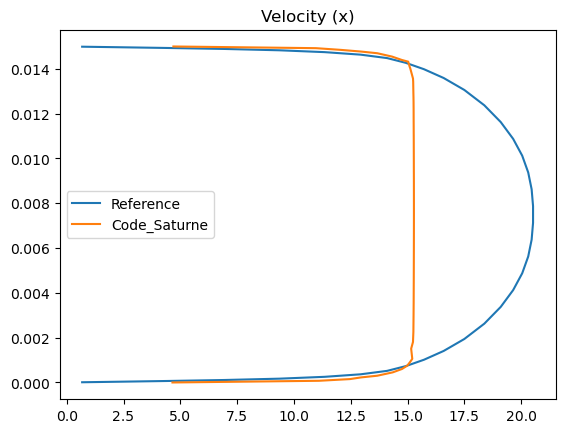

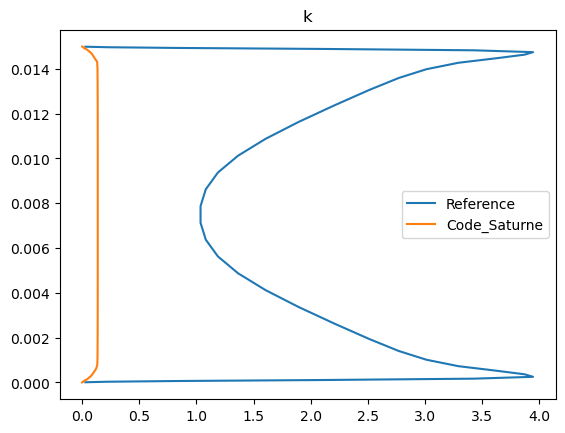

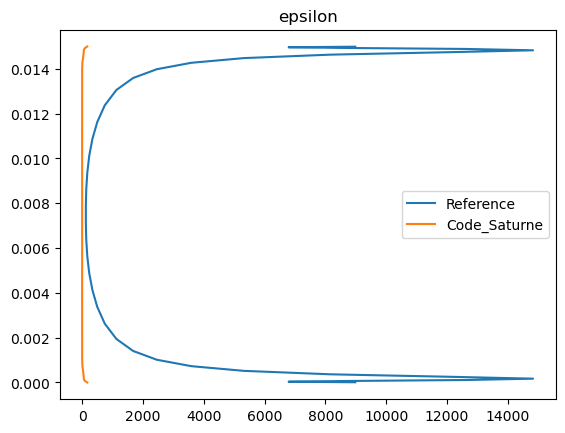

In [6]:
global Diffuser_h
Diffuser_h =0.015
global U_ref
U_ref = 18.32


data = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/Inlet_fully_developed.csv")

df = pd.read_csv("/home/juleslecoustre/Documents/InfiniteInlet/CASE1/RESU/Run4/profiles/Velocity.csv")
col2  = []
for col in df.columns:
    col2.append(str(col).strip(' '))
df.columns = col2

plt.plot(data["Velocity[i]"],data["Y"],label="Reference")
plt.plot(df["Velocity_x"],df["y"],label="Code_Saturne")
plt.legend()
plt.title("Velocity (x)")

plt.figure()
plt.plot(data["Turbulent Kinetic Energy"],data["Y"],label="Reference")
plt.plot(df["k"],df["y"],label="Code_Saturne")
plt.legend()
plt.title("k")

plt.figure()
plt.plot(data["Turbulent Dissipation Rate"],data["Y"],label="Reference")
plt.plot(df["epsilon"],df["y"],label="Code_Saturne")
plt.legend()
plt.title("epsilon")
plt.show()